Assignment
In this assignment, you'll continue working with the house prices data. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Load the houseprices data from Thinkful's database.
2. Reimplement your model from the previous checkpoint.
3. Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices', con=engine)

#engine.dispose()

df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
features = ['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 'firstflrsf', 'grlivarea', 'fullbath', 'totrmsabvgrd', 'garagecars', 'garagearea']

In [4]:
#df['yearbuilt_garageyrblt'] = df.yearbuilt * df.garageyrblt
#features.append('yearbuilt_garageyrblt')
#features.remove('yearbuilt')
#features.remove('garageyrblt')

df['grlivarea_totrmsabvgrd'] = df.grlivarea * df.totrmsabvgrd
features.append('grlivarea_totrmsabvgrd')
features.remove('grlivarea')
features.remove('totrmsabvgrd')

#df['firstflrsf_totalbsmtsf'] = df.firstflrsf + df.totalbsmtsf
#features.append('firstflrsf_totalbsmtsf')
#features.remove('firstflrsf')
#features.remove('totalbsmtsf')

df['garagearea_garagecars'] = df.garagearea * df.garagecars
features.append('garagearea_garagecars')
features.remove('garagearea')
features.remove('garagecars')

# reset feature list
#features = ['overallqual', 'yearbuilt', 'yearremodadd', 'grlivarea', 'fullbath', 'totrmsabvgrd', 'garagecars', 'garagearea']

df['inside_sf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
features.append('inside_sf')

df['outside_sf'] = df.wooddecksf + df.openporchsf
features.append('outside_sf')

features

['overallqual',
 'yearbuilt',
 'yearremodadd',
 'totalbsmtsf',
 'firstflrsf',
 'fullbath',
 'grlivarea_totrmsabvgrd',
 'garagearea_garagecars',
 'inside_sf',
 'outside_sf']

In [5]:
#Y = df.saleprice
Y = np.log1p(df.saleprice)

X = df[features]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [7]:
# We add constant to the model as it's a best practice
# to do so everytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     504.0
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:16:27   Log-Likelihood:                 401.92
No. Observations:                1168   AIC:                            -781.8
Df Residuals:                    1157   BIC:                            -726.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3

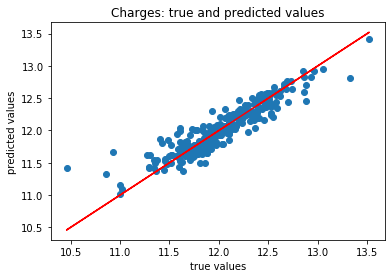

Mean absolute error of the prediction is: 0.11262695940013033
Mean squared error of the prediction is: 0.025632506665405907
Root mean squared error of the prediction is: 0.16010155110243593
Mean absolute percentage error of the prediction is: 0.9446605373445258


In [8]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?

#### OLS

In [9]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     663.8
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:16:27   Log-Likelihood:                 523.83
No. Observations:                1460   AIC:                            -1026.
Df Residuals:                    1449   BIC:                            -967.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.0988      0.578      5.360      0.000       1.965       4.233
overallqual                0.0952      0.005     17.880      0.000       0.085       0.106
yearbuilt                  0.0018      0.000      8.295      0.000       0.001       0.002
yearremodadd               0.0021      0.000      7.185      0.000       0.001       0.003
totalbsmtsf               -0.0003   3.65e-05     -7.679      0.000      -0.000      -0.000
firstflrsf              5.697e-05   2.21e-05      2.581      0.010    1.37e-05       0.000
fullbath                  -0.0095      0.012     -0.799      0.424      -0.033       0.014
grlivarea_totrmsabvgrd -1.023e-05   2.33e-06     -4.380      0.000   -1.48e-05   -5.65e-06
garagearea_garagecars   7.032e-05   8.59e-06      8.191      0.000    5.35e-05    8.72e-05
inside_sf                  0.0004    3.2e-05     11.055      0.000       0.000       0.000
outside_sf                 0.0002   3.41e-05      4.655      0.000    9.19e-05       0.000
==============================================================================
Omnibus:                      984.687   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39174.208
Skew:                          -2.594   Prob(JB):                         0.00
Kurtosis:                      27.840   Cond. No.                     1.69e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### LASSO

In [10]:
lasso_cv = Lasso(alpha=10**20.5) 
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0013312851260176561
Mean absolute error of the prediction is: 0.3178243812258433
Mean squared error of the prediction is: 0.1669676348189956
Root mean squared error of the prediction is: 0.4086167334055173
Mean absolute percentage error of the prediction is: 2.6437648221337366


#### RIDGE

In [11]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridge_cv = Ridge(alpha=10**37) 
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0013312851260176561
Mean absolute error of the prediction is: 0.3178243812258433
Mean squared error of the prediction is: 0.1669676348189956
Root mean squared error of the prediction is: 0.4086167334055173
Mean absolute percentage error of the prediction is: 2.6437648221337366


#### ELASTICNET

In [12]:
elastic_cv = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elastic_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elastic_cv.predict(X_train)
y_preds_test = elastic_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elastic_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elastic_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0013312851260176561
Mean absolute error of the prediction is: 0.3178243812258433
Mean squared error of the prediction is: 0.1669676348189956
Root mean squared error of the prediction is: 0.4086167334055173
Mean absolute percentage error of the prediction is: 2.6437648221337366


#### Best model: OLS